In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("data/credit_scoring_sample.csv", sep=";")

In [3]:
def delete_nan(table):
    for name in table.columns:
        table[name] = table[name].fillna(table[name].median())
    return table

In [4]:
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


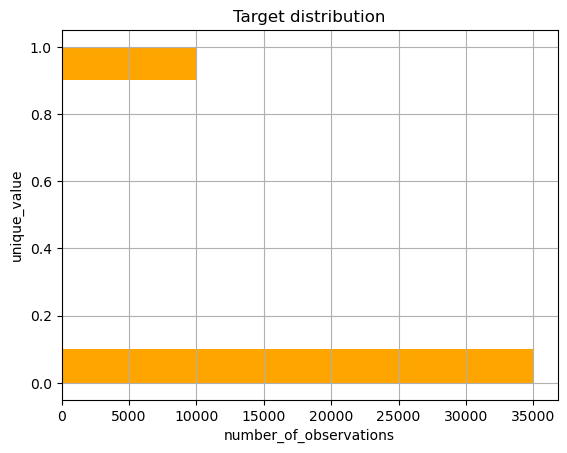

In [5]:
## Посмотрим на распределение классов в зависимой переменной
ax = data['SeriousDlqin2yrs'].hist(orientation="horizontal", color="orange");
ax.set_xlabel("number_of_observations");
ax.set_ylabel("unique_value");
ax.set_title("Target distribution");

In [6]:
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

In [7]:
independent_columns_names = data.columns.values[1:]

In [8]:
independent_columns_names

array(['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse',
       'MonthlyIncome', 'NumberOfDependents'], dtype=object)

In [9]:
table = delete_nan(data)

In [10]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

In [11]:
table.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,5166.0,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


### Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте np.random.seed(0), как это сделано в статье.

In [12]:
mark = table['age'][table['SeriousDlqin2yrs'] == 1] 
mean_value = np.mean(mark)
std_value = np.std(mark)
interval = 1.65 * (std_value/(len(mark) ** 0.5)) # Откуда 1.65? Я посмотрел значение в таблице 0.90/2 = 0.45(http://statsoft.ru/home/textbook/modules/sttable.html#z) пересечение 1.6 и 0.05
print(f"{mean_value - interval} - {mean_value + interval}")

45.71375922582052 - 46.13942250168797


### Продолжение 

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [14]:
lr = LogisticRegression(random_state=5, class_weight='balanced')

In [15]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

### Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [16]:
grid_search_lr = GridSearchCV(lr, parameters, scoring='roc_auc', cv=skf)

In [17]:
grid_search_lr.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
             scoring='roc_auc')

### Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [18]:
grid_search_lr.cv_results_['std_test_score']

array([0.00729217, 0.00813756, 0.00795378, 0.00516369, 0.00745782,
       0.00517589])

In [19]:
best_score = grid_search_lr.best_score_

In [20]:
best_score

0.8089120626797153

### Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()

In [23]:
best_model = grid_search_lr.best_estimator_

In [24]:
scaler.fit(best_model.coef_)

StandardScaler()

In [25]:
the_best_feature = pd.DataFrame({'coef':scaler.mean_, 'coef_abs': np.abs(scaler.mean_)}, index=X.columns)

In [26]:
the_best_feature.sort_values(by='coef_abs', ascending=False)

,coef,coef_abs
NumberOfTime30-59DaysPastDueNotWorse,0.460291,0.460291
NumberOfTimes90DaysLate,0.404556,0.404556
NumberOfTime60-89DaysPastDueNotWorse,0.237946,0.237946
NumberOfDependents,0.165761,0.165761
age,-0.013470,0.013470
MonthlyIncome,-0.000011,0.000011
DebtRatio,-0.000008,0.000008


### Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией softmax)

In [27]:
from scipy.special import softmax

In [28]:
the_best_feature['softmax'] = softmax(the_best_feature['coef'])

In [29]:
the_best_feature

,coef,coef_abs,softmax
age,-0.013470,0.013470,0.115818
NumberOfTime30-59DaysPastDueNotWorse,0.460291,0.460291,0.186007
DebtRatio,-0.000008,0.000008,0.117388
NumberOfTimes90DaysLate,0.404556,0.404556,0.175923
NumberOfTime60-89DaysPastDueNotWorse,0.237946,0.237946,0.148924
MonthlyIncome,-0.000011,0.000011,0.117387
NumberOfDependents,0.165761,0.165761,0.138553


### Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть здесь)

In [30]:
lr = LogisticRegression(C=0.001, random_state=17, class_weight='balanced')
lr.fit(X,y)

pd.DataFrame({'coef': lr.coef_.flatten()}, index=independent_columns_names).sort_values(by='coef', ascending=False)

,coef
NumberOfTime30-59DaysPastDueNotWorse,0.460291
NumberOfTimes90DaysLate,0.404556
NumberOfTime60-89DaysPastDueNotWorse,0.237946
NumberOfDependents,0.165761
DebtRatio,-0.000008
MonthlyIncome,-0.000011
age,-0.013470


In [31]:
np.exp(lr.coef_[0][0]*20)

0.7638444215041504

### Случайный лес

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
rf = RandomForestClassifier(n_estimators=100,
                            n_jobs=-1,
                            class_weight='balanced',
                            oob_score=True,
                            random_state=17)
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

### На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [34]:
rf_grid = GridSearchCV(rf,parameters, cv=skf, n_jobs=-1, scoring='roc_auc')

In [35]:
rf_grid.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True,
                                              random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc')

In [36]:
rf_grid.best_score_ - best_score

0.02685282827063573

### Определите какой признак имеет самое слабое влияние.

In [37]:
pd.DataFrame({'coef':rf_grid.best_estimator_.feature_importances_}, index=independent_columns_names).sort_values(by='coef', ascending=False)

,coef
NumberOfTime30-59DaysPastDueNotWorse,0.293745
NumberOfTimes90DaysLate,0.280268
NumberOfTime60-89DaysPastDueNotWorse,0.164065
age,0.114623
DebtRatio,0.074039
MonthlyIncome,0.059649
NumberOfDependents,0.013610


### Бэггинг

In [38]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

In [39]:
bc = BaggingClassifier(LogisticRegression(class_weight='balanced'), 100, random_state=42)

In [40]:
search = RandomizedSearchCV(estimator=bc, 
                            param_distributions=parameters,
                            random_state=1,
                            n_iter=20,
                            cv=skf,
                            scoring="roc_auc",
                            n_jobs=-1,)

In [ ]:
search.fit(X,y)

In [ ]:
search.best_params_